<font color="green" size=5>1. Тщательный анализ данных.</font>

<font color="green" size=3>1.1)</font>
Исследовать данные на наличие пропусков и некорректных значений. Либо удалить их, либо сделать imputing (проинтерполировать).

<font color="green" size=3>1.2)</font>
Посмотреть на распределение целевой переменной. Идентифицировать аномалии. Решить, что делать: убрать выбросы из датасета или преобразовать целевую переменную (например, посредством преобразования Бокса-Кокса).

<font color="green" size=3>1.3)</font>
Проанализировать признаки. Отобрать те, которые лично вам кажутся наиболее важными. Посмотреть на их распределение (в том числе на попарные). Посмотреть на совместное распределение целевой переменной и выбранных признаков. 

<font color="green" size=3>1.4)</font>
Сформулировать гипотезы о том, какие сочетания признаков могут быть полезны. Добавить их (если придумаете). Подсказка: отрисуйте выборку на карте, посчитайте расстояние до важных объектов в этом городе, посчитайте статистики по районам и по ближайшим объектам (не забудьте, что эти статистики нужно считать по обучающей выборке!).    

<font color="green" size=3>1.5)</font>
Исследовать зависимость целевой переменной от признаков, отобранных на предыдущем шаге, используя корреляционный анализ. Использовать scipy.stats.spearmanr для вещественных признаков, scipy.stats.pointbiserialr для бинарных признаков, scipy.stats.chisquare для прочих категориальных признаков (основная гипотеза -- равномерное распределение целевой переменной по значениям категориального признака). Выводы делать на основании p-value.


<font color="green" size=5>2. Правильная подготовка данных для обучения.</font>

<font color="green" size=3>2.1)</font>
Разбить данные на training sample и validation sample. Не забыть выставить random_seed=2021. Размер валидационной выборки -- 20% от датасета.

<font color="green" size=3>2.2)</font>
Убедиться, что распределение целевой переменной (хотя бы её) на обучающей и валидационной выборках совпадают.


<font color="green" size=5>3. Обоснованный выбор алгоритма и его гиперпараметров.</font>

<font color="green" size=3>3.1)</font>
Рекомендуемое решение: использовать catboost.CatBoostRegressor или sklearn.ensemble.RandomForest. Нейросети вряд ли покажут более высокое качество, но пробовать не возбраняется. Можно использовать линейные модели, если вы умеете ими пользоваться и уверены, что они уместны в этой задаче. 

<font color="green" size=3>3.2)</font>
Если гиперпараметры подбирались, нужно обосновать необходимость в этом.
Учесть логику работы алгоритма. Не нужно делать one-hot encoding категориальных признаков при использовании CatBoostRegressor, нужно масштабировать признаки при работе с метрическими методами etc.


<font color="green" size=5>4. Грамотный подход к обучению модели.</font>

<font color="green" size=3>4.1)</font>
Отправляете решение на Kaggle -- делаете чекпоинт модели и коммит на GitHub / сохранение копии ноутбука с датой (так, чтобы вы могли сопоставить ноутбуки посылкам).

<font color="green" size=3>4.2)</font>
Ваше лучшее решение должно воспроизводиться. Если вы не можете его воспроизвести, то оно не учитывается при проверке.

<font color="green" size=5>5. Post-hoc анализ.</font>

<font color="green" size=3>5.1)</font>
Проанализировать важности признаков (рекомендуется использовать SHAP-values).

<font color="green" size=3>5.2)</font>
Соотнести полученную из модели важность признаков с гипотезами из пункта 1. Пояснить расхождения.

<font color="green" size=3>5.3)</font>
Сравнить распределение ошибок вашей первой и лучшей посылок при помощи теста Манна-Уитни (в том виде, в каком он был на лекции! В scipy.stats реализован тест для проверки гипотезы сдвига, а вас интересует гипотеза доминирования). Убедиться, что лучшая модель объективно лучше.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import missingno as msno

plt.style.use("seaborn")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,10)
%matplotlib inline

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
data_train = pd.read_csv("train.csv", sep=",", index_col=0)
data_test = pd.read_csv("test.csv", sep=",", index_col=0)

<font color="green" size=5>1. Тщательный анализ данных.</font>

<font color="green" size=3>1.1)</font>
Исследовать данные на наличие пропусков и некорректных значений. Либо удалить их, либо сделать imputing (проинтерполировать).
 - См. в juputer notebook "features_analysis.ipynb"

<font color="green" size=3>1.1) Выводы</font>

In [3]:
skip_columns = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]

In [4]:
data_train_skip_columns = data_train.drop(columns=skip_columns)
data_test_skip_columns = data_test.drop(columns=skip_columns)

In [5]:
# Признаки, в которых разное кол-во категорий для data_train и data_test
diff_number_of_cat_columns = ["Utilities", "Condition2", "HouseStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "Heating", "Electrical", "GarageQual"]      

<font color="green" size=3>1.2)</font>
Посмотреть на распределение целевой переменной. Идентифицировать аномалии. Решить, что делать: убрать выбросы из датасета или преобразовать целевую переменную (например, посредством преобразования Бокса-Кокса).

- См. в jupyter notebook "features_analysis.ipynb"

<font color="green" size=3>1.2) Выводы</font>

1) Удалять выбросы не буду, так как я уже это попробовал сделать специально для линейных моделей и это оказалось плохой идеей так как дорогие дома присутствуют в data_test_skip_columns и на них RMSE огромную ошибку получает.

2) Исходя из сравнения статистик(.descibe()) видно, какие признаки точно имеет смысл рассматривать, поэтому выделим их.

In [6]:
important_num_columns_1 = ["LotArea", "OverallQual", "YearBuilt", "TotalBsmtSF", "LowQualFinSF", "GrLivArea",
                         "TotRmsAbvGrd", "GarageYrBlt", "GarageCars", "GarageArea", "EnclosedPorch", "3SsnPorch"]

concat_num_columns = ["1stFlrSF", "2ndFlrSF"]


important_cat_columns_1 = ["MSZoning", "Street", "LandContour", "LandSlope", "BldgType",
                        "RoofStyle", "ExterQual", "Foundation", "BsmtQual", "BsmtExposure",
                        "Electrical", "KitchenQual", "GarageFinish"]

concat_cat_columns = ["Condition1", "Condition2"]

<font color="green" size=3>1.3)</font>
Проанализировать признаки. Отобрать те, которые лично вам кажутся наиболее важными. Посмотреть на их распределение (в том числе на попарные). Посмотреть на совместное распределение целевой переменной и выбранных признаков. 

- См. в jupyter notebook "features_analysis.ipynb"

<font color="green" size=3>1.3) Выводы</font>

#### numeric_data

In [7]:
train_num_columns = data_train_skip_columns.select_dtypes(include=np.number).columns.to_list()
test_num_columns = data_test_skip_columns.select_dtypes(include=np.number).columns.to_list()

In [8]:
important_num_columns_2 = ["MSSubClass", "LotFrontage", "LotArea", "OverallQual", "YearBuilt", "TotalBsmtSF", "GrLivArea", "GarageYrBlt",
                           "GarageCars", "GarageArea", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]

to_binary_num_columns = ["KitchenAbvGr", "Fireplaces"]

#### object data

In [9]:
train_obj_columns = data_train_skip_columns.select_dtypes(include="object").columns.to_list()
test_obj_columns = train_obj_columns

In [10]:
important_cat_columns_2 = ["MSZoning", "LotShape", "LandContour", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
                           "BldgType", "HouseStyle", "RoofStyle", "Exterior1st", "ExterQual", "ExterCond", "Foundation", 
                           "HeatingQC", "Electrical", "KitchenQual", "Functional", "PavedDrive", "SaleType"]

to_binary_cat_columns = ["CentralAir"]

In [11]:
all_important_num_columns = list(set(important_num_columns_1 + important_num_columns_2))
all_important_cat_columns = list(set(important_cat_columns_1 + important_cat_columns_2))

<font color="green" size=3>1.4)</font>
Сформулировать гипотезы о том, какие сочетания признаков могут быть полезны. Добавить их (если придумаете). Подсказка: отрисуйте выборку на карте, посчитайте расстояние до важных объектов в этом городе, посчитайте статистики по районам и по ближайшим объектам (не забудьте, что эти статистики нужно считать по обучающей выборке!). 

- См. в jupyter notebook "features_analysis.ipynb"

In [12]:
# "сконкатенируем" concat_num_columns
data_train_skip_columns["1stFlrSF+2ndFlrSF"] = data_train_skip_columns["1stFlrSF"] + data_train_skip_columns["2ndFlrSF"]
data_test_skip_columns["1stFlrSF+2ndFlrSF"] = data_test_skip_columns["1stFlrSF"] + data_test_skip_columns["2ndFlrSF"]
new_columns = ["1stFlrSF+2ndFlrSF"]

In [13]:
data_train_skip_columns["KitchenAbvGr_binary"] = data_train_skip_columns["KitchenAbvGr"].apply(lambda x: x if x == 1 else 0)
data_test_skip_columns["KitchenAbvGr_binary"] = data_test_skip_columns["KitchenAbvGr"].apply(lambda x: x if x == 1 else 0)
new_columns += ["KitchenAbvGr_binary"]

In [14]:
data_train_skip_columns["has_Fireplaces"] = data_train_skip_columns["Fireplaces"].apply(lambda x: x if x == 0 else 1)
data_test_skip_columns["has_Fireplaces"] = data_test_skip_columns["Fireplaces"].apply(lambda x: x if x == 0 else 1)
new_columns += ["has_Fireplaces"]

In [15]:
data_train_skip_columns["has_CentralAir"] = data_train_skip_columns["CentralAir"].apply(lambda x: 1 if x == "Y" else 0)
data_test_skip_columns["has_CentralAir"] = data_test_skip_columns["CentralAir"].apply(lambda x: 1 if x == "Y" else 0)
new_columns += ["has_CentralAir"]

In [16]:
# прежде чем создать новые признаки, заполним все пропуски в data_train_skip_columns и data_test_skip_columns

In [17]:
median_TotalBsmtSF = data_train_skip_columns["TotalBsmtSF"].median()
median_GarageCars = data_train_skip_columns["GarageCars"].median()
median_LotFrontage = data_train_skip_columns["LotFrontage"].median()
mode_BsmtExposure = data_train_skip_columns["BsmtExposure"].mode().item()
mode_Exterior1st = data_train_skip_columns["Exterior1st"].mode().item()
mode_GarageFinish = data_train_skip_columns["GarageFinish"].mode().item()
mode_KitchenQual = data_train_skip_columns["KitchenQual"].mode().item()
mode_MSZoning = data_train_skip_columns["MSZoning"].mode().item()
mode_BsmtQual = data_train_skip_columns["BsmtQual"].mode().item()
mode_Functional = data_train_skip_columns["Functional"].mode().item()
mode_SaleType = data_train_skip_columns["SaleType"].mode().item()
mode_Electrical = data_train_skip_columns["Electrical"].mode().item()
median_GarageArea = data_train_skip_columns["GarageArea"].median()

In [18]:
data_train_skip_columns["TotalBsmtSF"].fillna(value=median_TotalBsmtSF, inplace=True)
data_test_skip_columns["TotalBsmtSF"].fillna(value=median_TotalBsmtSF, inplace=True)

data_train_skip_columns["GarageCars"].fillna(value=median_GarageCars, inplace=True)
data_test_skip_columns["GarageCars"].fillna(value=median_GarageCars, inplace=True)

data_train_skip_columns["LotFrontage"].fillna(value=median_LotFrontage, inplace=True)
data_test_skip_columns["LotFrontage"].fillna(value=median_LotFrontage, inplace=True)

data_train_skip_columns["BsmtExposure"].fillna(value=mode_BsmtExposure, inplace=True)
data_test_skip_columns["BsmtExposure"].fillna(value=mode_BsmtExposure, inplace=True)

data_train_skip_columns["Exterior1st"].fillna(value=mode_Exterior1st, inplace=True)
data_test_skip_columns["Exterior1st"].fillna(value=mode_Exterior1st, inplace=True)

data_train_skip_columns["GarageFinish"].fillna(value=mode_GarageFinish, inplace=True)
data_test_skip_columns["GarageFinish"].fillna(value=mode_GarageFinish, inplace=True)

data_train_skip_columns["KitchenQual"].fillna(value=mode_KitchenQual, inplace=True)
data_test_skip_columns["KitchenQual"].fillna(value=mode_KitchenQual, inplace=True)

data_train_skip_columns["MSZoning"].fillna(value=mode_KitchenQual, inplace=True)
data_test_skip_columns["MSZoning"].fillna(value=mode_KitchenQual, inplace=True)

data_train_skip_columns["BsmtQual"].fillna(value=mode_BsmtQual, inplace=True)
data_test_skip_columns["BsmtQual"].fillna(value=mode_BsmtQual, inplace=True)

data_train_skip_columns["Functional"].fillna(value=mode_Functional, inplace=True)
data_test_skip_columns["Functional"].fillna(value=mode_Functional, inplace=True)

data_train_skip_columns["SaleType"].fillna(value=mode_SaleType, inplace=True)
data_test_skip_columns["SaleType"].fillna(value=mode_SaleType, inplace=True)

data_train_skip_columns["Electrical"].fillna(value=mode_Electrical, inplace=True)
data_test_skip_columns["Electrical"].fillna(value=mode_Electrical, inplace=True)

data_train_skip_columns["GarageArea"].fillna(value=median_GarageArea, inplace=True)
data_test_skip_columns["GarageArea"].fillna(value=median_GarageArea, inplace=True)

In [19]:
# GarageYrBlt - пропуски заполним YearBuilt так как гаражи очевидно строятся либо в момент постройки дома, либо чутка позже

In [20]:
data_train_skip_columns["GarageYrBlt"].fillna(value=0, inplace=True)
data_test_skip_columns["GarageYrBlt"].fillna(value=0, inplace=True)

In [21]:
data_train_skip_columns["GarageYrBlt"] = data_train_skip_columns[["GarageYrBlt", "YearBuilt"]].max(axis=1)
data_test_skip_columns["GarageYrBlt"] = data_test_skip_columns[["GarageYrBlt", "YearBuilt"]].max(axis=1)

In [22]:
# создадим несколько новых фичей, которые из логики могут быть полезны

In [23]:
data_train_skip_columns["Years"] = 2016 - data_train_skip_columns["YearRemodAdd"]
data_test_skip_columns["Years"] = 2016 - data_test_skip_columns["YearRemodAdd"]
new_columns += ["Years"]

In [24]:
data_train_skip_columns["has_pool"] = data_train_skip_columns["PoolArea"].apply(lambda x: x if x == 0 else 1)
data_test_skip_columns["has_pool"] = data_test_skip_columns["PoolArea"].apply(lambda x: x if x == 0 else 1)
new_columns += ["has_pool"]

In [25]:
data_train_skip_columns["OverallQual+Cond"] = data_train_skip_columns["OverallQual"] + data_train_skip_columns["OverallCond"]
data_test_skip_columns["OverallQual+Cond"] = data_test_skip_columns["OverallQual"] + data_test_skip_columns["OverallCond"]
new_columns += ["OverallQual+Cond"]

In [26]:
data_train_skip_columns["All_number_of_Bath"] = data_train_skip_columns['FullBath'] + 0.5*data_train_skip_columns['HalfBath']\
                                              + data_train_skip_columns['BsmtFullBath'] + 0.5*data_train_skip_columns['BsmtHalfBath']

data_test_skip_columns["All_number_of_Bath"] = data_test_skip_columns['FullBath'] + 0.5*data_test_skip_columns['HalfBath']\
                                             + data_test_skip_columns['BsmtFullBath'] + 0.5*data_test_skip_columns['BsmtHalfBath']

new_columns += ["All_number_of_Bath"]

In [27]:
data_train_skip_columns[new_columns].isna().sum()

1stFlrSF+2ndFlrSF      0
KitchenAbvGr_binary    0
has_Fireplaces         0
has_CentralAir         0
Years                  0
has_pool               0
OverallQual+Cond       0
All_number_of_Bath     0
dtype: int64

In [28]:
data_test_skip_columns[new_columns].isna().sum()

1stFlrSF+2ndFlrSF      0
KitchenAbvGr_binary    0
has_Fireplaces         0
has_CentralAir         0
Years                  0
has_pool               0
OverallQual+Cond       0
All_number_of_Bath     2
dtype: int64

In [29]:
mode_All_number_of_Bath = data_train_skip_columns["All_number_of_Bath"].mode().item()

In [30]:
data_test_skip_columns["All_number_of_Bath"].fillna(value=mode_All_number_of_Bath, inplace=True)

<font color="green" size=3>1.4) Выводы</font>

In [31]:
new_columns

['1stFlrSF+2ndFlrSF',
 'KitchenAbvGr_binary',
 'has_Fireplaces',
 'has_CentralAir',
 'Years',
 'has_pool',
 'OverallQual+Cond',
 'All_number_of_Bath']

<font color="green" size=3>1.5)</font>
Исследовать зависимость целевой переменной от признаков, отобранных на предыдущем шаге, используя корреляционный анализ. Использовать scipy.stats.spearmanr для вещественных признаков, scipy.stats.pointbiserialr для бинарных признаков, scipy.stats.chisquare для прочих категориальных признаков (основная гипотеза -- равномерное распределение целевой переменной по значениям категориального признака). Выводы делать на основании p-value.

- См. в jupyter notebook "features_analysis.ipynb"

In [32]:
all_important_num_columns

['OverallQual',
 'YearBuilt',
 'TotalBsmtSF',
 'OpenPorchSF',
 'ScreenPorch',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageArea',
 'GarageCars',
 '3SsnPorch',
 'MSSubClass',
 'EnclosedPorch',
 'LotArea',
 'GarageYrBlt',
 'LowQualFinSF',
 'LotFrontage']

In [33]:
new_columns

['1stFlrSF+2ndFlrSF',
 'KitchenAbvGr_binary',
 'has_Fireplaces',
 'has_CentralAir',
 'Years',
 'has_pool',
 'OverallQual+Cond',
 'All_number_of_Bath']

In [34]:
all_important_cat_columns

['SaleType',
 'GarageFinish',
 'LandContour',
 'Street',
 'MSZoning',
 'LotShape',
 'RoofStyle',
 'Functional',
 'BldgType',
 'ExterCond',
 'Neighborhood',
 'HeatingQC',
 'ExterQual',
 'KitchenQual',
 'PavedDrive',
 'Condition1',
 'HouseStyle',
 'BsmtQual',
 'Foundation',
 'Electrical',
 'BsmtExposure',
 'Exterior1st',
 'LotConfig',
 'LandSlope']

In [35]:
all_important_cat_columns_transformed = []

In [36]:
data_train_skip_columns["SaleType_transformed"] = data_train_skip_columns["SaleType"].apply(lambda x: x if x in ["WD", "New", "COD"] else "OtherSaleType")
data_test_skip_columns["SaleType_transformed"] = data_test_skip_columns["SaleType"].apply(lambda x: x if x in ["WD", "New", "COD"] else "OtherSaleType")

all_important_cat_columns_transformed += ["SaleType_transformed"]

In [37]:
all_important_cat_columns_transformed += ["LotConfig"]

In [38]:
data_train_skip_columns["Condition1_transformed"] = data_train_skip_columns["Condition1"].apply(lambda x: x if x in ["Norm", "Feedr"] else "OtherCondition1")
data_test_skip_columns["Condition1_transformed"] = data_test_skip_columns["Condition1"].apply(lambda x: x if x in ["Norm", "Feedr"] else "OtherCondition1")

all_important_cat_columns_transformed += ["Condition1_transformed"]

In [39]:
all_important_cat_columns_transformed += ["KitchenQual"]

In [40]:
all_important_cat_columns_transformed += ["MSZoning"]

In [41]:
all_important_cat_columns_transformed += ["BsmtQual"]

In [42]:
all_important_cat_columns_transformed += ["PavedDrive"]

In [43]:
all_important_cat_columns_transformed += ["LotShape"]

In [44]:
data_train_skip_columns["HeatingQC_transformed"] = data_train_skip_columns["HeatingQC"].apply(lambda x: x if x != "Po" else "Fa")
data_test_skip_columns["HeatingQC_transformed"] = data_test_skip_columns["HeatingQC"].apply(lambda x: x if x != "Po" else "Fa")

all_important_cat_columns_transformed += ["HeatingQC_transformed"]

In [45]:
all_important_cat_columns_transformed += ["Neighborhood"]

In [46]:
data_train_skip_columns["RoofStyle_transformed"] = data_train_skip_columns["RoofStyle"].apply(lambda x: x if x in ["Gable", "Hip"] else "OtherRoofStyle")
data_test_skip_columns["RoofStyle_transformed"] = data_test_skip_columns["RoofStyle"].apply(lambda x: x if x in ["Gable", "Hip"] else "OtherRoofStyle")

all_important_cat_columns_transformed += ["RoofStyle_transformed"]

In [47]:
data_train_skip_columns["Electrical_transformed"] = data_train_skip_columns["Electrical"].apply(lambda x: x if x not in ["Mix", "FuseP"] else "OtherElectrical")
data_test_skip_columns["Electrical_transformed"] = data_test_skip_columns["Electrical"].apply(lambda x: x if x not in ["Mix", "FuseP"] else "OtherElectrical")

all_important_cat_columns_transformed += ["Electrical_transformed"]

In [48]:
all_important_cat_columns_transformed += ["GarageFinish"]

In [49]:
all_important_cat_columns_transformed += ["LandSlope"]

In [50]:
all_important_cat_columns_transformed += ["ExterQual"]

In [51]:
data_train_skip_columns["Exterior1st_transformed"] = data_train_skip_columns["Exterior1st"].apply(lambda x: x if x not in ['BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'] else "OtherExterior1st")
data_test_skip_columns["Exterior1st_transformed"] = data_test_skip_columns["Exterior1st"].apply(lambda x: x if x not in ['BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'] else "OtherExterior1st")

all_important_cat_columns_transformed += ["Exterior1st_transformed"]

In [52]:
all_important_cat_columns_transformed += ["LandContour"]

In [53]:
all_important_cat_columns_transformed += ["HouseStyle"]

In [54]:
all_important_cat_columns_transformed += ["Foundation"]

In [55]:
data_train_skip_columns["ExterCond_transformed"] = data_train_skip_columns["ExterCond"].apply(lambda x: x if x in ["TA", "Gd"] else "OtherExterCond")
data_test_skip_columns["ExterCond_transformed"] = data_test_skip_columns["ExterCond"].apply(lambda x: x if x in ["TA", "Gd"] else "OtherExterCond")

all_important_cat_columns_transformed += ["ExterCond_transformed"]

In [56]:
all_important_cat_columns_transformed += ["BldgType"]

In [57]:
data_train_skip_columns["Functional_transformed"] = data_train_skip_columns["Functional"].apply(lambda x: x if x in ["Typ", "Min1", "Maj1", "Min2", "Mod"] else "OtherFunctional")
data_test_skip_columns["Functional_transformed"] = data_test_skip_columns["Functional"].apply(lambda x: x if x in ["Typ", "Min1", "Maj1", "Min2", "Mod"] else "OtherFunctional")

all_important_cat_columns_transformed += ["Functional_transformed"]

In [58]:
all_important_cat_columns_transformed += ["BsmtExposure"]

In [59]:
all_important_cat_columns_transformed += ["Street"]

<font color="green" size=3>1.5) Выводы</font>

По итогу выделяем те признаки, которые нас интересуют и в дальнейшем будем работать уже с нимми

In [60]:
all_important_num_columns

['OverallQual',
 'YearBuilt',
 'TotalBsmtSF',
 'OpenPorchSF',
 'ScreenPorch',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageArea',
 'GarageCars',
 '3SsnPorch',
 'MSSubClass',
 'EnclosedPorch',
 'LotArea',
 'GarageYrBlt',
 'LowQualFinSF',
 'LotFrontage']

In [61]:
new_columns

['1stFlrSF+2ndFlrSF',
 'KitchenAbvGr_binary',
 'has_Fireplaces',
 'has_CentralAir',
 'Years',
 'has_pool',
 'OverallQual+Cond',
 'All_number_of_Bath']

In [62]:
all_important_cat_columns_transformed

['SaleType_transformed',
 'LotConfig',
 'Condition1_transformed',
 'KitchenQual',
 'MSZoning',
 'BsmtQual',
 'PavedDrive',
 'LotShape',
 'HeatingQC_transformed',
 'Neighborhood',
 'RoofStyle_transformed',
 'Electrical_transformed',
 'GarageFinish',
 'LandSlope',
 'ExterQual',
 'Exterior1st_transformed',
 'LandContour',
 'HouseStyle',
 'Foundation',
 'ExterCond_transformed',
 'BldgType',
 'Functional_transformed',
 'BsmtExposure',
 'Street']

<font color="green" size=5>2. Правильная подготовка данных для обучения.</font>

<font color="green" size=3>2.1)</font>
Разбить данные на training sample и validation sample. Не забыть выставить random_seed=2021. Размер валидационной выборки -- 20% от датасета.

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
training_sample, testing_sample = train_test_split(data_train_skip_columns[all_important_num_columns + new_columns + all_important_cat_columns_transformed + ["SalePrice"]], test_size=0.2, random_state=2021)

<font color="green" size=3>2.2)</font>
Убедиться, что распределение целевой переменной (хотя бы её) на обучающей и валидационной выборках совпадают.

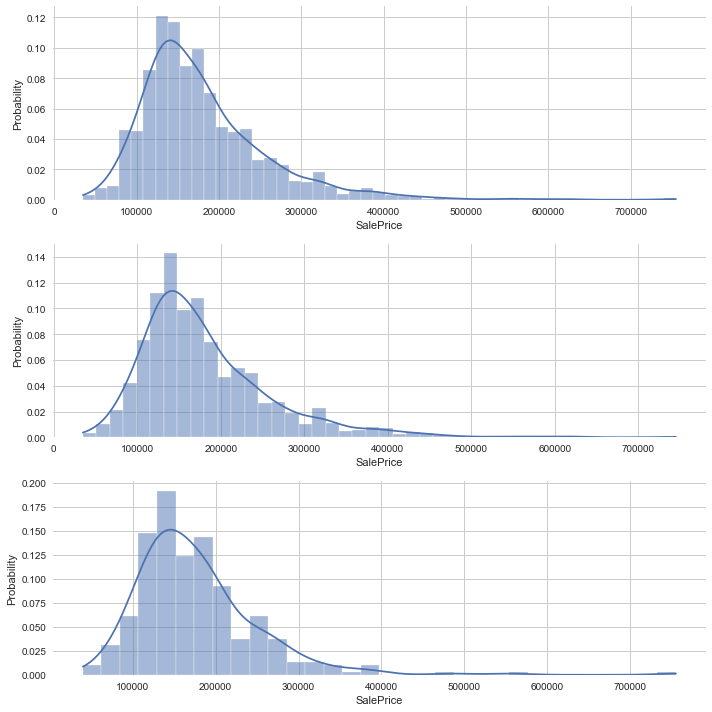

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(10, 10)
sns.histplot(data=data_train_skip_columns["SalePrice"], kde=True, stat="probability", ax=ax1)
sns.histplot(data=training_sample["SalePrice"], kde=True, stat="probability", ax=ax2)
sns.histplot(data=testing_sample["SalePrice"], kde=True, stat="probability", ax=ax3);

plt.tight_layout()

In [66]:
# как можно заметить распределения целевой переменной в data_train_skip_columns["SalePrice"], training_sample["SalePrice"], testing_sample["SalePrice"]
# не сильно различаются визуально
 
# проверка с помощью стат. критеририев

print("Колмогоров-Смирнов непараметрический двухвыборочный")
print(sp.stats.ks_2samp(data_train_skip_columns["SalePrice"].values.reshape(-1, ), training_sample["SalePrice"].values.reshape(-1, )))
print(sp.stats.ks_2samp(training_sample["SalePrice"].values.reshape(-1, ), testing_sample["SalePrice"].values.reshape(-1, )))
print(sp.stats.ks_2samp(testing_sample["SalePrice"].values.reshape(-1, ), data_train_skip_columns["SalePrice"].values.reshape(-1, )), end="\n\n")

print("Двухвыборочный критерий Андерсена непараметрический")
print(sp.stats.anderson_ksamp([data_train_skip_columns["SalePrice"].values.reshape(-1, ), training_sample["SalePrice"].values.reshape(-1, )], ))
print(sp.stats.anderson_ksamp([training_sample["SalePrice"].values.reshape(-1, ), testing_sample["SalePrice"].values.reshape(-1, )]))
print(sp.stats.anderson_ksamp([testing_sample["SalePrice"].values.reshape(-1, ), data_train_skip_columns["SalePrice"].values.reshape(-1, )]))

Колмогоров-Смирнов непараметрический двухвыборочный
KstestResult(statistic=0.00993150684931507, pvalue=0.9999998992672332)
KstestResult(statistic=0.04965753424657534, pvalue=0.6016476686591672)
KstestResult(statistic=0.03972602739726028, pvalue=0.8274740200771361)

Двухвыборочный критерий Андерсена непараметрический
Anderson_ksampResult(statistic=-1.2371452016175688, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Anderson_ksampResult(statistic=-0.6127961063982562, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Anderson_ksampResult(statistic=-0.8375893409405769, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)


In [67]:
# прежде чем переходить к обучению моделей, необходимо устранить ещё небольшую проблемку
data_train_skip_columns[all_important_cat_columns_transformed].describe().loc["unique"] == data_test_skip_columns[all_important_cat_columns_transformed].describe().loc["unique"]

SaleType_transformed        True
LotConfig                   True
Condition1_transformed      True
KitchenQual                 True
MSZoning                   False
BsmtQual                    True
PavedDrive                  True
LotShape                    True
HeatingQC_transformed       True
Neighborhood                True
RoofStyle_transformed       True
Electrical_transformed      True
GarageFinish                True
LandSlope                   True
ExterQual                   True
Exterior1st_transformed     True
LandContour                 True
HouseStyle                 False
Foundation                  True
ExterCond_transformed       True
BldgType                    True
Functional_transformed      True
BsmtExposure                True
Street                      True
Name: unique, dtype: bool

In [68]:
data_train_skip_columns["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [69]:
data_test_skip_columns["MSZoning"].value_counts()

RL         1114
RM          242
FV           74
C (all)      15
RH           10
TA            4
Name: MSZoning, dtype: int64

In [70]:
data_test_skip_columns["MSZoning"].replace("TA", "RL", inplace=True)

In [71]:
data_train_skip_columns["HouseStyle"].value_counts()                

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [72]:
data_test_skip_columns["HouseStyle"].value_counts() 
# здесь кол-во градаций категории меньше, так что тут всё в порядке

1Story    745
2Story    427
1.5Fin    160
SLvl       63
SFoyer     46
2.5Unf     13
1.5Unf      5
Name: HouseStyle, dtype: int64

<font color="green" size=5>3. Обоснованный выбор алгоритма и его гиперпараметров.</font>

<font color="green" size=3>3.1)</font>
Рекомендуемое решение: использовать catboost.CatBoostRegressor или sklearn.ensemble.RandomForest. Нейросети вряд ли покажут более высокое качество, но пробовать не возбраняется. Можно использовать линейные модели, если вы умеете ими пользоваться и уверены, что они уместны в этой задаче. 

 <font color="green" size=3>3.2)</font>
Если гиперпараметры подбирались, нужно обосновать необходимость в этом.
Учесть логику работы алгоритма. Не нужно делать one-hot encoding категориальных признаков при использовании CatBoostRegressor, нужно масштабировать признаки при работе с метрическими методами etc.

<font color="green" size=5>4. Грамотный подход к обучению модели.</font>

<font color="green" size=3>4.1)</font>
Отправляете решение на Kaggle -- делаете чекпоинт модели и коммит на GitHub / сохранение копии ноутбука с датой (так, чтобы вы могли сопоставить ноутбуки посылкам).

<font color="green" size=3>4.2)</font>
Ваше лучшее решение должно воспроизводиться. Если вы не можете его воспроизвести, то оно не учитывается при проверке.

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn
from sklearn.compose import ColumnTransformer

In [74]:
# начнём с создания pipeline

In [75]:
num_pipeline = Pipeline([
    ("standart_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("cat_encoder", OneHotEncoder(drop="if_binary", sparse=False))
])

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, all_important_num_columns+new_columns), 
    ("cat", cat_pipeline, all_important_cat_columns_transformed)
])

In [76]:
# начнём с чего-нибудь простенького, к примеру с линейных моделей

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [78]:
lin_reg = LinearRegression()

In [79]:
lasso_reg = Lasso()

In [80]:
ridge_reg = Ridge()

In [81]:
preprocess_predict_pipeline_lin_reg = Pipeline([
    ("preprocessor", preprocess_pipeline),
    ("lin_reg", lin_reg)
])

preprocess_predict_pipeline_lasso_reg = Pipeline([
    ("preprocessor", preprocess_pipeline),
    ("lasso_reg", lasso_reg)
])

preprocess_predict_pipeline_ridge_reg = Pipeline([
    ("preprocessor", preprocess_pipeline),
    ("ridge_reg", ridge_reg)
])

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#### lin_reg

In [83]:
cv_results_lin_reg = cross_val_score(estimator=preprocess_predict_pipeline_lin_reg,
                             X=training_sample[all_important_num_columns+new_columns+all_important_cat_columns_transformed],
                             y=training_sample["SalePrice"],
                             scoring="neg_root_mean_squared_error",
                             cv=10,
                             verbose=5,
                             n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    2.4s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    2.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


In [84]:
cv_results_lin_reg

array([-23521.20998163, -26752.36949838, -32759.35410867, -31597.36267381,
       -52060.60249183,             nan, -35719.51349328, -22244.40387227,
       -23171.33056859, -41897.11373985])

In [85]:
cv_results_lin_reg[~np.isnan(cv_results_lin_reg)].mean()

-32191.473380922915

In [86]:
param_grid_lin_reg = {
    "preprocessor__cat__cat_encoder__drop": ["if_binary", None]
}

grid_lin_reg = GridSearchCV(estimator=preprocess_predict_pipeline_lin_reg,
                           param_grid=param_grid_lin_reg,
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1,
                           cv=10,
                           verbose=5)
grid_lin_reg.fit(training_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns], training_sample["SalePrice"])

Fitting 10 folds for each of 2 candidates, totalling 20 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standart_scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          'OpenPorchSF',
                                                                          'ScreenPorch',
                                                                          'GrLivArea',
                                                                          'TotRmsAbvGrd',
    

In [87]:
grid_lin_reg.best_params_, grid_lin_reg.best_score_

({'preprocessor__cat__cat_encoder__drop': 'if_binary'}, nan)

In [88]:
best_lin_reg = grid_lin_reg.best_estimator_

In [89]:
from sklearn.metrics import mean_squared_error

In [90]:
mean_squared_error(
    best_lin_reg.predict(testing_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns]),
    testing_sample["SalePrice"],
    squared=False
)

28328.546905229225

#### lasso_reg

In [91]:
%%time
cv_results_lasso_reg = cross_val_score(estimator=preprocess_predict_pipeline_lasso_reg,
                             X=training_sample[all_important_num_columns+new_columns+all_important_cat_columns_transformed],
                             y=training_sample["SalePrice"],
                             scoring="neg_root_mean_squared_error",
                             cv=10,
                             verbose=5,
                             n_jobs=-1)
cv_results_lasso_reg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Wall time: 452 ms


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


array([-23482.8526943 , -26687.63643382, -32737.12757308, -31550.95590501,
       -52011.22435146,             nan, -35716.69842509, -22214.07402911,
       -23174.32924521, -41868.63833161])

In [92]:
cv_results_lasso_reg[~np.isnan(cv_results_lasso_reg)].mean()

-32160.39299874287

In [93]:
param_grid_lasso_reg = {
    "lasso_reg__alpha": np.linspace(0.1, 100, 10),
    "lasso_reg__warm_start": [True, False],
    "lasso_reg__random_state": [2021],
    "lasso_reg__selection": ["cyclic", "random"],
    "preprocessor__cat__cat_encoder__drop": ["if_binary", None]
}

grid_lasso_reg = GridSearchCV(estimator=preprocess_predict_pipeline_lasso_reg,
                           param_grid=param_grid_lasso_reg,
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1,
                           cv=10,
                           verbose=5)
grid_lasso_reg.fit(training_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns], training_sample["SalePrice"])

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standart_scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          'OpenPorchSF',
                                                                          'ScreenPorch',
                                                                          'GrLivArea',
                                                                          'TotRmsAbvGrd',
    

In [94]:
grid_lasso_reg.best_params_, grid_lasso_reg.best_score_

({'lasso_reg__alpha': 0.1,
  'lasso_reg__random_state': 2021,
  'lasso_reg__selection': 'cyclic',
  'lasso_reg__warm_start': True,
  'preprocessor__cat__cat_encoder__drop': 'if_binary'},
 nan)

In [95]:
best_lasso_reg = grid_lasso_reg.best_estimator_

In [96]:
mean_squared_error(
    best_lasso_reg.predict(testing_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns]),
    testing_sample["SalePrice"],
    squared=False
)

28325.269292475095

#### ridge_reg

In [97]:
%%time
cv_results_ridge_reg = cross_val_score(estimator=preprocess_predict_pipeline_ridge_reg,
                             X=training_sample[all_important_num_columns+new_columns+all_important_cat_columns_transformed],
                             y=training_sample["SalePrice"],
                             scoring="neg_root_mean_squared_error",
                             cv=10,
                             verbose=5,
                             n_jobs=-1)
cv_results_ridge_reg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Wall time: 187 ms


array([-23173.81961179, -26221.46426303, -32610.81359094, -30982.99343969,
       -52224.05383875,             nan, -35667.4967653 , -21863.27095447,
       -23156.93688886, -41511.20752001])

In [98]:
cv_results_ridge_reg[~np.isnan(cv_results_ridge_reg)].mean()

-31934.672985869194

In [99]:
param_grid_ridge_reg = {
    "ridge_reg__alpha": np.linspace(0.1, 100, 10),
    "ridge_reg__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
    "ridge_reg__random_state": [2021],
    "preprocessor__cat__cat_encoder__drop": ["if_binary", None]
}

grid_ridge_reg = GridSearchCV(estimator=preprocess_predict_pipeline_ridge_reg,
                           param_grid=param_grid_ridge_reg,
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1,
                           cv=10,
                           verbose=5)
grid_ridge_reg.fit(training_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns], training_sample["SalePrice"])

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standart_scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          'OpenPorchSF',
                                                                          'ScreenPorch',
                                                                          'GrLivArea',
                                                                          'TotRmsAbvGrd',
    

In [100]:
grid_ridge_reg.best_params_, grid_ridge_reg.best_score_

({'preprocessor__cat__cat_encoder__drop': 'if_binary',
  'ridge_reg__alpha': 0.1,
  'ridge_reg__random_state': 2021,
  'ridge_reg__solver': 'auto'},
 nan)

In [101]:
best_ridge_reg = grid_ridge_reg.best_estimator_

In [102]:
mean_squared_error(
    best_ridge_reg.predict(testing_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns]),
    testing_sample["SalePrice"],
    squared=False
)

28258.034568971772

In [103]:
# по итогу обучим best_ridge_reg на data_train_skip_columns и сделаем submit on kaggle

In [104]:
best_ridge_reg.fit(
    X=data_train_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns],
    y=data_train_skip_columns["SalePrice"]
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standart_scaler',
                                                                   StandardScaler())]),
                                                  ['OverallQual', 'YearBuilt',
                                                   'TotalBsmtSF', 'OpenPorchSF',
                                                   'ScreenPorch', 'GrLivArea',
                                                   'TotRmsAbvGrd', 'GarageArea',
                                                   'GarageCars', '3SsnPorch',
                                                   'MSSubClass',
                                                   'EnclosedPorch', 'LotArea',
                                                   'GarageYrBlt',
                                                   'LowQualFinSF',
                                                   'LotFronta

In [105]:
predict_best_ridge_reg = best_ridge_reg.predict(data_test_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns])

In [106]:
# submit on kaggle best_ridge_reg

In [107]:
df_predict_best_ridge_reg = pd.DataFrame(data=predict_best_ridge_reg, index=data_test_skip_columns.index, columns=["SalePrice"])

In [108]:
df_predict_best_ridge_reg.to_csv("best_ridge_reg_1.csv", index=True, header=True)
# Your submission scored 0.34231

### kn_reg

In [109]:
# также рассмотрим KNeighborsRegressor исходя из предположения, что похожие по характеристикам дома стоят примерно одинакого
from sklearn.neighbors import KNeighborsRegressor

In [110]:
kn_reg = KNeighborsRegressor()

In [111]:
preprocess_predict_pipeline_kn_reg = Pipeline([
    ("preprocessor", preprocess_pipeline),
    ("kn_reg", kn_reg)
])

In [112]:
%%time
cv_results_kn_reg = cross_val_score(estimator=preprocess_predict_pipeline_kn_reg,
                             X=training_sample[all_important_num_columns+new_columns+all_important_cat_columns_transformed],
                             y=training_sample["SalePrice"],
                             scoring="neg_root_mean_squared_error",
                             cv=10,
                             verbose=5,
                             n_jobs=-1)
cv_results_kn_reg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Wall time: 272 ms


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


array([-29576.21454831, -26604.46851927, -37071.07194731, -43110.34936557,
       -44431.77249605,             nan, -43201.95334439, -33229.0799174 ,
       -29216.78378007, -43633.1216512 ])

In [113]:
cv_results_kn_reg[~np.isnan(cv_results_kn_reg)].mean()
# гораздо хуже результат ... 

-36674.9795077298

In [114]:
param_grid_kn_reg = {
    "kn_reg__n_neighbors": [i for i in range(2, 10)],
    "kn_reg__weights": ["uniform", "distance"],
    "kn_reg__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "kn_reg__leaf_size": [i for i in range(5, 101, 5)],
    "kn_reg__p": [1, 2, 3],
    "preprocessor__cat__cat_encoder__drop": ["if_binary", None]
}

grid_kn_reg = GridSearchCV(estimator=preprocess_predict_pipeline_kn_reg,
                           param_grid=param_grid_kn_reg,
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1,
                           cv=10,
                           verbose=5)
grid_kn_reg.fit(training_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns], training_sample["SalePrice"])

Fitting 10 folds for each of 7680 candidates, totalling 76800 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standart_scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          'OpenPorchSF',
                                                                          'ScreenPorch',
                                                                          'GrLivArea',
                                                                          'TotRmsAbvGrd',
    

In [115]:
grid_kn_reg.best_params_, grid_kn_reg.best_score_

({'kn_reg__algorithm': 'auto',
  'kn_reg__leaf_size': 5,
  'kn_reg__n_neighbors': 2,
  'kn_reg__p': 1,
  'kn_reg__weights': 'uniform',
  'preprocessor__cat__cat_encoder__drop': 'if_binary'},
 nan)

In [116]:
best_kn_reg = grid_kn_reg.best_estimator_

In [117]:
mean_squared_error(
    best_kn_reg.predict(testing_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns]),
    testing_sample["SalePrice"],
    squared=False
)

29174.263631027112

In [118]:
# обучим на всех данных 

In [119]:
best_kn_reg.fit(
    X=data_train_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns],
    y=data_train_skip_columns["SalePrice"]
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standart_scaler',
                                                                   StandardScaler())]),
                                                  ['OverallQual', 'YearBuilt',
                                                   'TotalBsmtSF', 'OpenPorchSF',
                                                   'ScreenPorch', 'GrLivArea',
                                                   'TotRmsAbvGrd', 'GarageArea',
                                                   'GarageCars', '3SsnPorch',
                                                   'MSSubClass',
                                                   'EnclosedPorch', 'LotArea',
                                                   'GarageYrBlt',
                                                   'LowQualFinSF',
                                                   'LotFronta

In [120]:
predict_best_kn_reg = best_kn_reg.predict(data_test_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns])

In [121]:
# submit on kaggle best_kn_reg

In [122]:
df_predict_best_kn_reg = pd.DataFrame(data=predict_best_kn_reg, index=data_test_skip_columns.index, columns=["SalePrice"])

In [123]:
df_predict_best_kn_reg.to_csv("best_kn_reg_1.csv", index=True, header=True)
# Your submission scored 0.17192, which is an improvement of your previous score of 0.30675. Great job!

In [124]:
# неплохое увеличение score по сравнению с линейными моделями, предлагаю ещё попробовать погонять GridSearchCV

In [125]:
param_grid_kn_reg_2 = {
    "kn_reg__algorithm": ["auto"],
    "kn_reg__n_neighbors": [1, 2, 3],
    "kn_reg__weights": ["uniform", "distance"],
    "kn_reg__leaf_size": [i for i in range(1, 20)],
    "kn_reg__metric": ["chebyshev", "manhattan"],
    "preprocessor__cat__cat_encoder__drop": ["if_binary"]
}

grid_kn_reg_2 = GridSearchCV(estimator=preprocess_predict_pipeline_kn_reg,
                           param_grid=param_grid_kn_reg_2,
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1,
                           cv=10,
                           verbose=5)
grid_kn_reg_2.fit(training_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns], training_sample["SalePrice"])

Fitting 10 folds for each of 228 candidates, totalling 2280 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standart_scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          'OpenPorchSF',
                                                                          'ScreenPorch',
                                                                          'GrLivArea',
                                                                          'TotRmsAbvGrd',
    

In [126]:
grid_kn_reg_2.best_params_, grid_kn_reg_2.best_score_

({'kn_reg__algorithm': 'auto',
  'kn_reg__leaf_size': 1,
  'kn_reg__metric': 'chebyshev',
  'kn_reg__n_neighbors': 1,
  'kn_reg__weights': 'uniform',
  'preprocessor__cat__cat_encoder__drop': 'if_binary'},
 nan)

In [127]:
best_kn_reg_2 = grid_kn_reg_2.best_estimator_

In [128]:
mean_squared_error(
    best_kn_reg_2.predict(testing_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns]),
    testing_sample["SalePrice"],
    squared=False
)
# визуально явное переобучение .... 

50036.050863694734

In [129]:
best_kn_reg_2.fit(
    X=data_train_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns],
    y=data_train_skip_columns["SalePrice"]
)

predict_best_kn_reg_2 = best_kn_reg_2.predict(data_test_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns])

In [130]:
df_predict_best_kn_reg_2 = pd.DataFrame(data=predict_best_kn_reg_2, index=data_test_skip_columns.index, columns=["SalePrice"])

In [131]:
df_predict_best_kn_reg_2.to_csv("best_kn_reg_2.csv", index=True, header=True)
# Your submission scored 0.23645

#### rf_reg

In [132]:
from sklearn.ensemble import RandomForestRegressor

In [133]:
rf_reg = RandomForestRegressor()

In [134]:
preprocess_predict_pipeline_rf_reg = Pipeline([
    ("preprocessor", preprocess_pipeline),
    ("rf_reg", rf_reg)
])

In [135]:
%%time
cv_results_rf_reg = cross_val_score(estimator=preprocess_predict_pipeline_rf_reg,
                             X=training_sample[all_important_num_columns+new_columns+all_important_cat_columns_transformed],
                             y=training_sample["SalePrice"],
                             scoring="neg_root_mean_squared_error",
                             cv=10,
                             verbose=5,
                             n_jobs=-1)
cv_results_rf_reg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   10.8s remaining:   43.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   10.9s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:   11.3s remaining:    2.7s


Wall time: 11.6 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.5s finished


array([-24468.4162604 , -23458.45130174, -34460.3012867 , -27451.4799277 ,
       -42889.9723839 ,             nan, -34411.50912667, -22280.30812341,
       -28042.67797349, -43787.89769426])

In [136]:
cv_results_rf_reg[~np.isnan(cv_results_rf_reg)].mean()

-31250.112675363678

In [137]:
param_grid_rf_reg = {
    "rf_reg__n_estimators": [10, 50 ,100],
    "rf_reg__max_depth" : [1, 5, 10, 20],
    "rf_reg__min_samples_split": [2, 3, 4, 5, 6],
    "rf_reg__max_features": ["auto", "sqrt", "log2"],
    "rf_reg__random_state": [2021],
    "rf_reg__warm_start": [True, False],
    "preprocessor__cat__cat_encoder__drop": ["if_binary", None]
}

grid_rf_reg = GridSearchCV(estimator=preprocess_predict_pipeline_rf_reg,
                          param_grid=param_grid_rf_reg,
                          scoring="neg_root_mean_squared_error",
                          n_jobs=-1,
                          cv=5,
                          verbose=5)

grid_rf_reg.fit(training_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns], training_sample["SalePrice"])

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standart_scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          'OpenPorchSF',
                                                                          'ScreenPorch',
                                                                          'GrLivArea',
                                                                          'TotRmsAbvGrd',
     

In [138]:
grid_rf_reg.best_params_, grid_rf_reg.best_score_

({'preprocessor__cat__cat_encoder__drop': 'if_binary',
  'rf_reg__max_depth': 1,
  'rf_reg__max_features': 'auto',
  'rf_reg__min_samples_split': 2,
  'rf_reg__n_estimators': 10,
  'rf_reg__random_state': 2021,
  'rf_reg__warm_start': True},
 nan)

In [139]:
best_rf_reg = grid_rf_reg.best_estimator_

In [140]:
mean_squared_error(
    best_rf_reg.predict(testing_sample[all_important_num_columns+all_important_cat_columns_transformed+new_columns]),
    testing_sample["SalePrice"],
    squared=False
)
# визуально модель переобучилась на training_sample

58145.74566426491

In [141]:
best_rf_reg.fit(
    X=data_train_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns],
    y=data_train_skip_columns["SalePrice"]
)

predict_best_rf_reg = best_rf_reg.predict(data_test_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns])

In [142]:
df_predict_best_rf_reg = pd.DataFrame(data=predict_best_rf_reg, index=data_test_skip_columns.index, columns=["SalePrice"])

In [143]:
df_predict_best_rf_reg.to_csv("best_rf_reg.csv", index=True, header=True)
# 0.31956

In [144]:
# предполагаю, что модель банально переобучилась на training_sample, попробуем просто обучить на всём data_train_skip_columns стандартый rf

In [145]:
preprocess_predict_pipeline_rf_reg.fit(
    X=data_train_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns],
    y=data_train_skip_columns["SalePrice"]
)

predict_standart_rf_reg = preprocess_predict_pipeline_rf_reg.predict(data_test_skip_columns[all_important_num_columns+all_important_cat_columns_transformed+new_columns])

In [146]:
df_predict_standart_rf_reg = pd.DataFrame(data=predict_standart_rf_reg, index=data_test_skip_columns.index, columns=["SalePrice"])

In [147]:
df_predict_standart_rf_reg.to_csv("standart_rf_reg.csv", index=True, header=True)
# Your submission scored 0.14477, which is an improvement of your previous score of 0.17192. Great job!

In [148]:
df_predict_standart_rf_reg

,SalePrice
Id,
1461,122549.91
1462,151158.50
1463,168964.22
1464,179499.14
1465,203874.06
...,...
2915,86709.00
2916,84659.00
2917,156101.37


<font color="green" size=5>5. Post-hoc анализ.</font>

<font color="green" size=3>5.1)</font>
Проанализировать важности признаков (рекомендуется использовать SHAP-values).

<font color="green" size=3>5.2)</font>
Соотнести полученную из модели важность признаков с гипотезами из пункта 1. Пояснить расхождения.

<font color="green" size=3>5.3)</font>
Сравнить распределение ошибок вашей первой и лучшей посылок при помощи теста Манна-Уитни (в том виде, в каком он был на лекции! В scipy.stats реализован тест для проверки гипотезы сдвига, а вас интересует гипотеза доминирования). Убедиться, что лучшая модель объективно лучше.